# Adversarial Validation（对抗验证）


https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation/notebook

https://github.com/Qiuyan918/Adversarial_Validation_Case_Study/blob/master/Adversarial_Validation.ipynb

https://www.jianshu.com/p/a91dfcd15940


https://www.cnblogs.com/MiQing4in/p/13397596.html

https://www.kaggle.com/code/famazon/adversarial-validation-set

In [1]:
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
# Memory management
import gc
gc.enable()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv

In [2]:
df_all = pd.read_csv('./input/dataset.csv') 
df_all.shape 

(91713, 85)

In [3]:
df_all.select_dtypes(include=['object'])

,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,Caucasian,M,Floor,admit,CTICU,Sepsis,Cardiovascular
1,Caucasian,F,Floor,admit,Med-Surg ICU,Respiratory,Respiratory
2,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU,Metabolic,Metabolic
3,Caucasian,F,Operating Room / Recovery,admit,CTICU,Cardiovascular,Cardiovascular
4,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,Trauma,Trauma
...,...,...,...,...,...,...,...
91708,Caucasian,M,Floor,admit,Cardiac ICU,Sepsis,Cardiovascular
91709,Caucasian,F,Floor,admit,Med-Surg ICU,Sepsis,Cardiovascular
91710,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,Metabolic,Metabolic
91711,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU,Respiratory,Respiratory


In [4]:
df_all.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'age', 'bmi',
       'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source',
       'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative',
       'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache',
       'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache',
       'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_

# 初步剔除一些无效特征
1. 只有一个值的特征
2. 缺失值超过90%的特征
3. 某个值占比超过90%的特征

In [5]:
#初步进行数据清理 去除无意义的变量
# 只有一个值的特征
one_value_cols = [col for col in df_all.columns if df_all[col].nunique() <= 1]
print("只有一个值的特征:\n",one_value_cols)
print("\n")

# 缺失值超过90%的特征
many_null_cols = [col for col in df_all.columns if df_all[col].isnull().sum() / df_all.shape[0] > 0.9]
print("缺失值超过90%的特征:\n",many_null_cols)
print("\n")

# 某个值占比超过90%的特征
big_top_value_cols = [col for col in df_all.columns if df_all[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
print("某个值占比超过90%的特征:\n",big_top_value_cols)

print("\n")

cols_to_drop = list(set(many_null_cols  + big_top_value_cols  + one_value_cols ))
cols_to_drop.remove('hospital_death') # 标签从待删除特征中剔除
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

print("清洗数据集前:",df_all.shape)
df_all = df_all.drop(cols_to_drop, axis=1)
print("清洗数据集后:",df_all.shape)

只有一个值的特征:
 ['Unnamed: 83']


缺失值超过90%的特征:
 ['Unnamed: 83']


某个值占比超过90%的特征:
 ['icu_stay_type', 'arf_apache', 'gcs_unable_apache', 'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'Unnamed: 83', 'hospital_death']


11 features are going to be dropped for being useless
清洗数据集前: (91713, 85)
清洗数据集后: (91713, 74)


In [6]:
X = df_all.drop(['hospital_death'],axis=1)
y = df_all['hospital_death']
df_train,df_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=1)

In [7]:
temp_train = pd.concat([df_train, y_train], axis=1)
temp_test = pd.concat([df_test, y_test], axis=1)

In [8]:
%%time
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
        df_train[col] = le.transform(list(df_train[col].astype(str).values))
        df_test[col] = le.transform(list(df_test[col].astype(str).values))

CPU times: user 667 ms, sys: 47.9 ms, total: 715 ms
Wall time: 724 ms


# 对抗验证（Adversarial Validatiion）

In [9]:
train_copy = df_train.copy() # 用于逻辑回归 归一化的数据集
test_copy = df_test.copy()

# 定义新的Y
df_train['Is_Test'] = 0
df_test['Is_Test'] = 1



df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df_all_shuffled = df_all.sample(frac=1)

features = df_all_shuffled.columns

X = df_all_shuffled.drop(['Is_Test'], axis=1)
y = df_all_shuffled['Is_Test']

In [10]:
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {
          "eval_metric":"auc",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

8    0.503763
Name: test-auc-mean, dtype: float64


In [11]:
res = []
res.append(['XGboost',cross_val_results["test-auc-mean"].iloc[-1]])

In [12]:
res

[['XGboost', 0.5037626000000001]]

<Figure size 1800x1200 with 0 Axes>

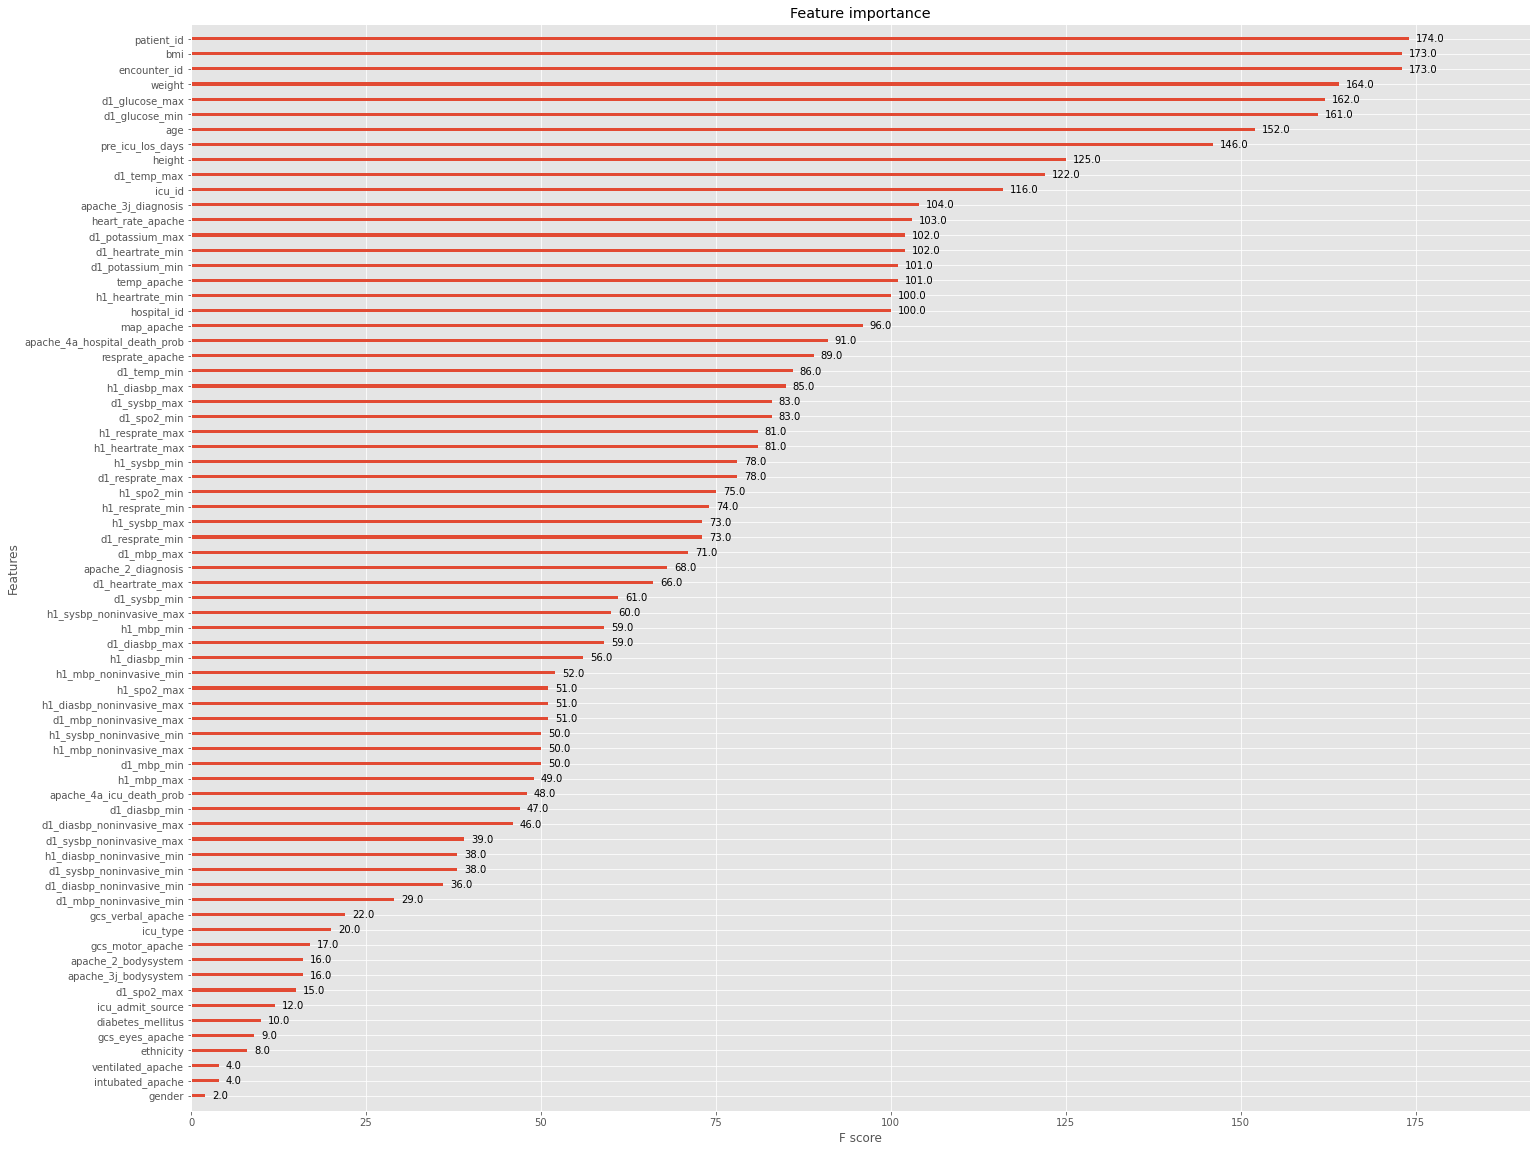

In [13]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
plt.figure(dpi = 300)
fig, ax = plt.subplots(figsize=(24,20))
plot_importance(classifier, ax=ax)
plt.show();

In [14]:
from scipy import stats
features_list = features.values.tolist()
for feature in features_list:
    statistic, pvalue = stats.kstest(df_train[feature], df_test[feature])
    print("p-value %.2f" %pvalue, "for the feature",feature)

p-value 0.35 for the feature encounter_id
p-value 0.61 for the feature patient_id
p-value 0.38 for the feature hospital_id
p-value 0.04 for the feature age
p-value 0.92 for the feature bmi
p-value 1.00 for the feature elective_surgery
p-value 1.00 for the feature ethnicity
p-value 1.00 for the feature gender
p-value 0.99 for the feature height
p-value 0.87 for the feature icu_admit_source
p-value 0.94 for the feature icu_id
p-value 1.00 for the feature icu_type
p-value 0.08 for the feature pre_icu_los_days
p-value 0.82 for the feature weight
p-value 0.01 for the feature apache_2_diagnosis
p-value 0.83 for the feature apache_3j_diagnosis
p-value 1.00 for the feature apache_post_operative
p-value 0.98 for the feature gcs_eyes_apache
p-value 1.00 for the feature gcs_motor_apache
p-value 0.98 for the feature gcs_verbal_apache
p-value 0.19 for the feature heart_rate_apache
p-value 1.00 for the feature intubated_apache
p-value 0.60 for the feature map_apache
p-value 0.07 for the feature resp

In [15]:
# # AUC值为0.5左右 说明测试集和训练集样本分布均匀
# # 保存数据 x_train,x_test,y_train,y_test
# temp_train.to_csv('./input/train.csv',index=False)
# temp_test.to_csv('./input/test.csv',index=False)

In [16]:
plot_df = pd.DataFrame(res,columns=['method','AUC'])

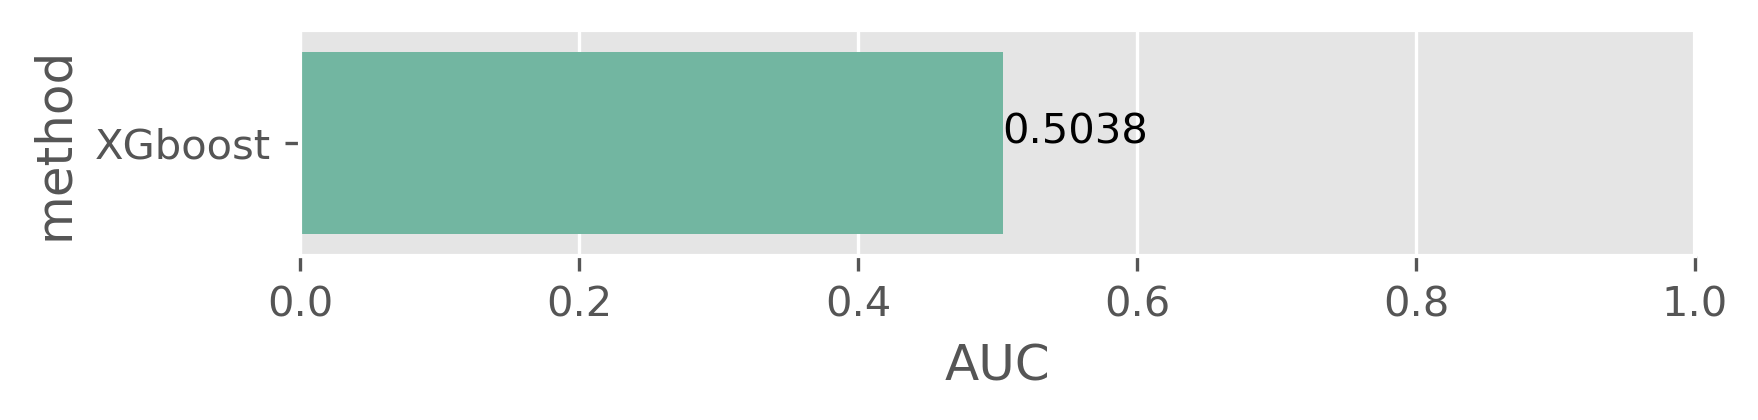

In [17]:
# 可视化 测试集上 AUC的评分
plt.figure(figsize=(6,1),dpi=300) # 分辨率设为300 字体清晰
plt.xlim((0, 1))

g = sns.barplot('AUC', plot_df['method'], data=plot_df, palette=sns.color_palette("Set2"), orient='h')
for idx,row_df in plot_df.iterrows():
    g.text(row_df['AUC'],idx,format(row_df['AUC'], '.4f'),ha="left") # x,y,显示的数字